In [4]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import pprint
import csv
import ast
import sys


from collections import Counter
from operator import itemgetter

import sqlite3 as sql
from sqlalchemy import create_engine
from sqlalchemy import text

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

import re

In [6]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [7]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [8]:
query = """
SELECT DISTINCT ?item  ?itemLabel  ?gender ?year
        WHERE {
            {
            {?item wdt:P106 wd:Q169470}
            UNION
            {?item wdt:P101 wd:Q413}  
          UNION 
          {?item wdt:P106 wd:Q11063}
            UNION
            {?item wdt:P101 wd:Q333} 
            UNION
              {?item wdt:P106 wd:Q155647}
            UNION
            {?item wdt:P101 wd:Q34362} 
              }
          
          ?item wdt:P31 wd:Q5;  # Any instance of a human.
              wdt:P569 ?birthDate;
                wdt:P21 ?gender.
        BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
        FILTER(xsd:integer(?year) > 1350 )
          
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        } 
     ORDER BY ?year
"""

In [10]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

<class 'dict'>
33886


[['http://www.wikidata.org/entity/Q855257',
  'Blasius of Parma',
  'http://www.wikidata.org/entity/Q6581097',
  '1355'],
 ['http://www.wikidata.org/entity/Q4121967',
  'Ibn al-Majdi',
  'http://www.wikidata.org/entity/Q6581097',
  '1359'],
 ['http://www.wikidata.org/entity/Q9168741',
  'Benedict Makra',
  'http://www.wikidata.org/entity/Q6581097',
  '1360']]

In [11]:
### Créer un DataFrame à partir du résultat
df_b = pd.DataFrame(r)
df_b.columns = ['personUri', 'personLabel', 'genderUri', 'birthYear']
df_b.head()

,personUri,personLabel,genderUri,birthYear
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360
3,http://www.wikidata.org/entity/Q45439746,Hu Guan,http://www.wikidata.org/entity/Q6581097,1361
4,http://www.wikidata.org/entity/Q1386256,Qāḍī Zāda al-Rūmī,http://www.wikidata.org/entity/Q6581097,1364


In [12]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33886 entries, 0 to 33885
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    33886 non-null  object
 1   personLabel  33886 non-null  object
 2   genderUri    33886 non-null  object
 3   birthYear    33886 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [13]:
chemin='sqlite:///../../data/astronomers_import.db'


In [14]:
engine=create_engine(chemin)


In [15]:
### Tester iune requête SQL sur une table existante
l = []
with engine.connect() as cn:
   l = cn.execute(text("SELECT * FROM person limit 3")).fetchall()

In [16]:
l

[(1, 'Ibn al-Majdi', 1359, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Ibn_al-Majdi', None),
 (2, 'Ulugh Beg', 1394, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Ulugh_Beg', None),
 (3, 'Luca Pacioli', 1447, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Luca_Pacioli', None)]

In [17]:
cn = sql.connect('../../data/astronomers_import.db')
cn

In [18]:
### Tester une requête SQL sur une table existante
cur = cn.cursor()
l = cur.execute("SELECT * FROM person limit 3").fetchall()

In [19]:
[print(e) for e in l]

(1, 'Ibn al-Majdi', 1359, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Ibn_al-Majdi', None)
(2, 'Ulugh Beg', 1394, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Ulugh_Beg', None)
(3, 'Luca Pacioli', 1447, None, None, "Importé le 15 mars 2024 depuis le résultat d'une requête SPARQL sur DBPedia, cf. astronomers/DBpedia_importer_dans_base_personnelle", 'http://dbpedia.org/resource/Luca_Pacioli', None)


[None, None, None]

In [20]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, un message d'erreur est renvoyé
try:
    l = df_b.to_sql(name='wdt_personne', con=cn, if_exists='fail')
except Exception as e:
    print('Erreur: ',  e)

Erreur:  Table 'wdt_personne' already exists.


In [21]:
### Tester une requête SQL sur une table existante
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_personne limit 3").fetchall()

In [22]:
[print(e) for e in l]

(0, 'http://www.wikidata.org/entity/Q855257', 'Blasius of Parma', 'http://www.wikidata.org/entity/Q6581097', '1355')
(1, 'http://www.wikidata.org/entity/Q4121967', 'Ibn al-Majdi', 'http://www.wikidata.org/entity/Q6581097', '1359')
(2, 'http://www.wikidata.org/entity/Q9168741', 'Benedict Makra', 'http://www.wikidata.org/entity/Q6581097', '1360')


[None, None, None]

In [23]:
query = """
SELECT genderUri, count(*) as eff
FROM wdt_personne
GROUP BY genderUri
ORDER BY eff DESC"""

In [24]:
cur = cn.cursor()

In [25]:
res = cur.execute(query)

In [26]:
res.fetchall()

[('http://www.wikidata.org/entity/Q6581097', 30965),
 ('http://www.wikidata.org/entity/Q6581072', 2901),
 ('http://www.wikidata.org/entity/Q1052281', 7),
 ('http://www.wikidata.org/entity/Q48270', 3),
 ('http://www.wikidata.org/entity/Q505371', 1),
 ('http://www.wikidata.org/entity/Q27679766', 1),
 ('http://www.wikidata.org/entity/Q2449503', 1),
 ('http://www.wikidata.org/.well-known/genid/2bfa7fe6cfda223fdfdd54784aca1f45',
  1)]

In [27]:
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        a = 'F'
    else:
        a = 'A'
    return a    

In [28]:
df_b['genCode'] = df_b.apply(lambda x: code_gender(x['genderUri']), axis=1)

In [29]:
df_b[df_b['genCode']=='A'][:10]

,personUri,personLabel,genderUri,birthYear,genCode
19315,http://www.wikidata.org/entity/Q62729141,Arnold Schmidt,http://www.wikidata.org/entity/Q2449503,1938,A
24722,http://www.wikidata.org/entity/Q42207726,A. W. Peet,http://www.wikidata.org/entity/Q48270,1950,A
24723,http://www.wikidata.org/entity/Q42207726,A. W. Peet,http://www.wikidata.org/entity/Q27679766,1950,A
25023,http://www.wikidata.org/entity/Q2540350,Jessica Mink,http://www.wikidata.org/entity/Q1052281,1951,A
26260,http://www.wikidata.org/entity/Q15990211,Rachael Padman,http://www.wikidata.org/entity/Q1052281,1954,A
29395,http://www.wikidata.org/entity/Q5400926,Estelle Asmodelle,http://www.wikidata.org/entity/Q1052281,1964,A
30495,http://www.wikidata.org/entity/Q124414761,JA Grier,http://www.wikidata.org/entity/Q48270,1968,A
31315,http://www.wikidata.org/entity/Q4886322,Rebecca Oppenheimer,http://www.wikidata.org/entity/Q1052281,1972,A
32026,http://www.wikidata.org/entity/Q43875924,Anne M. Archibald,http://www.wikidata.org/entity/Q1052281,1976,A
32449,http://www.wikidata.org/entity/Q23656158,Lucianne M. Walkowicz,http://www.wikidata.org/entity/Q48270,1979,A


## Effectifs par année

In [34]:
### Transformer le type de valeur de la colonne BirthYear
# de objet à entier
df_b['birthYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 33886 entries, 0 to 33885
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
33886 non-null  object
dtypes: object(1)
memory usage: 264.9+ KB


In [35]:
df_b['birthYear'] = df_b['birthYear'].astype(int)

In [36]:
years_count = pd.DataFrame(df_b[df_b['birthYear'] < 2002].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1355,1
1,1359,1
2,1360,1
3,1361,1
4,1364,1
...,...,...
577,1996,6
578,1997,3
579,1998,3
580,1999,3


In [37]:
min(years_count['year']), max(years_count['year'])

(1355, 2000)

In [38]:
l_50 = list(range(1351, 2050, 50))
l_50[:5],l_50[-5:]

([1351, 1401, 1451, 1501, 1551], [1801, 1851, 1901, 1951, 2001])

In [39]:
l_50[0]=1355
l_50[-1]=2000
l_50

[1355,
 1401,
 1451,
 1501,
 1551,
 1601,
 1651,
 1701,
 1751,
 1801,
 1851,
 1901,
 1951,
 2000]

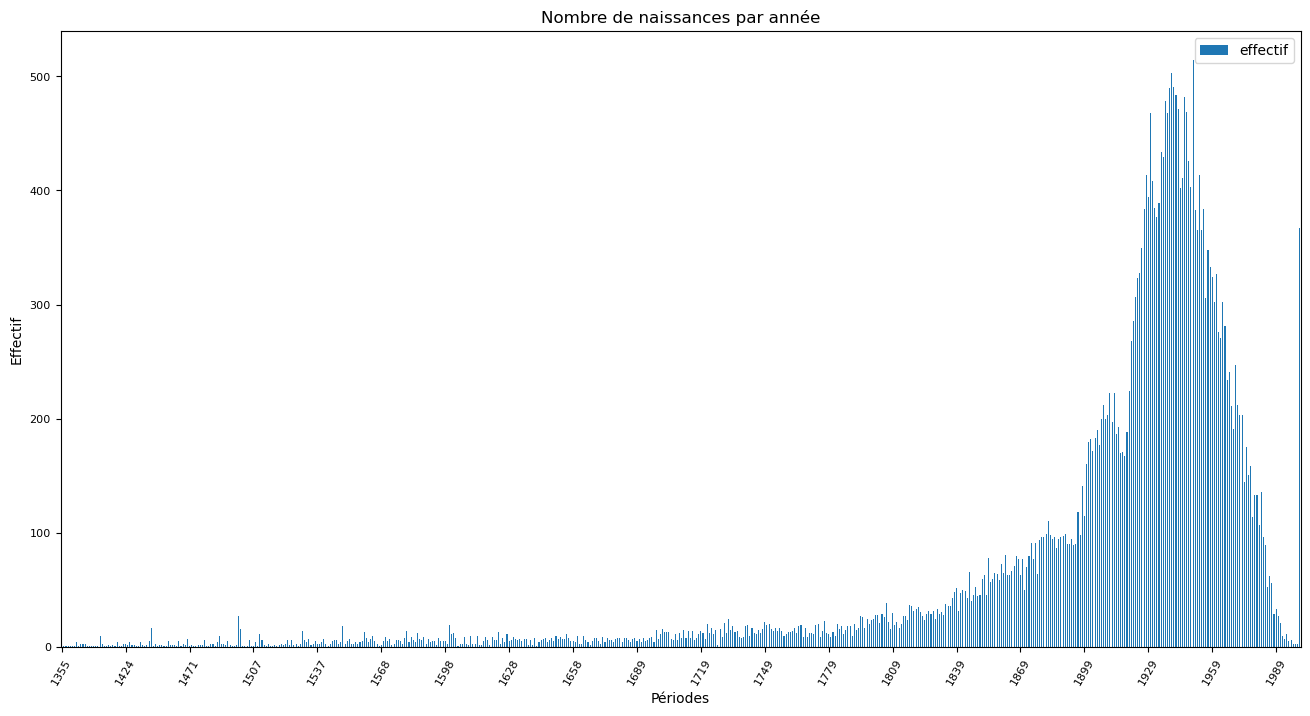

In [40]:
ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper par périodes de 25 ans

In [41]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_b = df_b[df_b['birthYear'] < 2001].copy(deep=True)

In [42]:
cdf_b.head(3)

,personUri,personLabel,genderUri,birthYear,genCode
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355,M
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359,M
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360,M


### Codage par période de vingt-cinq ans

In [43]:
l_25 = list(range(1351, 2002, 25))
l_25[:5],l_25[-5:]

([1351, 1376, 1401, 1426, 1451], [1901, 1926, 1951, 1976, 2001])

In [44]:

## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html


cdf_b['periodes'] = pd.cut(cdf_b['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_b['periodes'] = cdf_b['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_b.head(3)

,personUri,personLabel,genderUri,birthYear,genCode,periodes
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355,M,1351-1375
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359,M,1351-1375
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360,M,1351-1375


In [45]:
cdf_b[cdf_b.birthYear == 2000][:3]

,personUri,personLabel,genderUri,birthYear,genCode,periodes
33430,http://www.wikidata.org/entity/Q64452,Tom Murphy,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000
33431,http://www.wikidata.org/entity/Q335266,Brian P. Roman,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000
33432,http://www.wikidata.org/entity/Q12246830,Michel Hayek,http://www.wikidata.org/entity/Q6581097,2000,M,1976-2000


In [46]:
cdf_b.groupby(by='periodes').size()

periodes
1351-1375       15
1376-1400       22
1401-1425       25
1426-1450       41
1451-1475       45
1476-1500       82
1501-1525       84
1526-1550      116
1551-1575      127
1576-1600      164
1601-1625      149
1626-1650      151
1651-1675      151
1676-1700      173
1701-1725      282
1726-1750      357
1751-1775      357
1776-1800      434
1801-1825      679
1826-1850     1009
1851-1875     1700
1876-1900     2499
1901-1925     5354
1926-1950    10924
1951-1975     7043
1976-2000     1814
dtype: int64

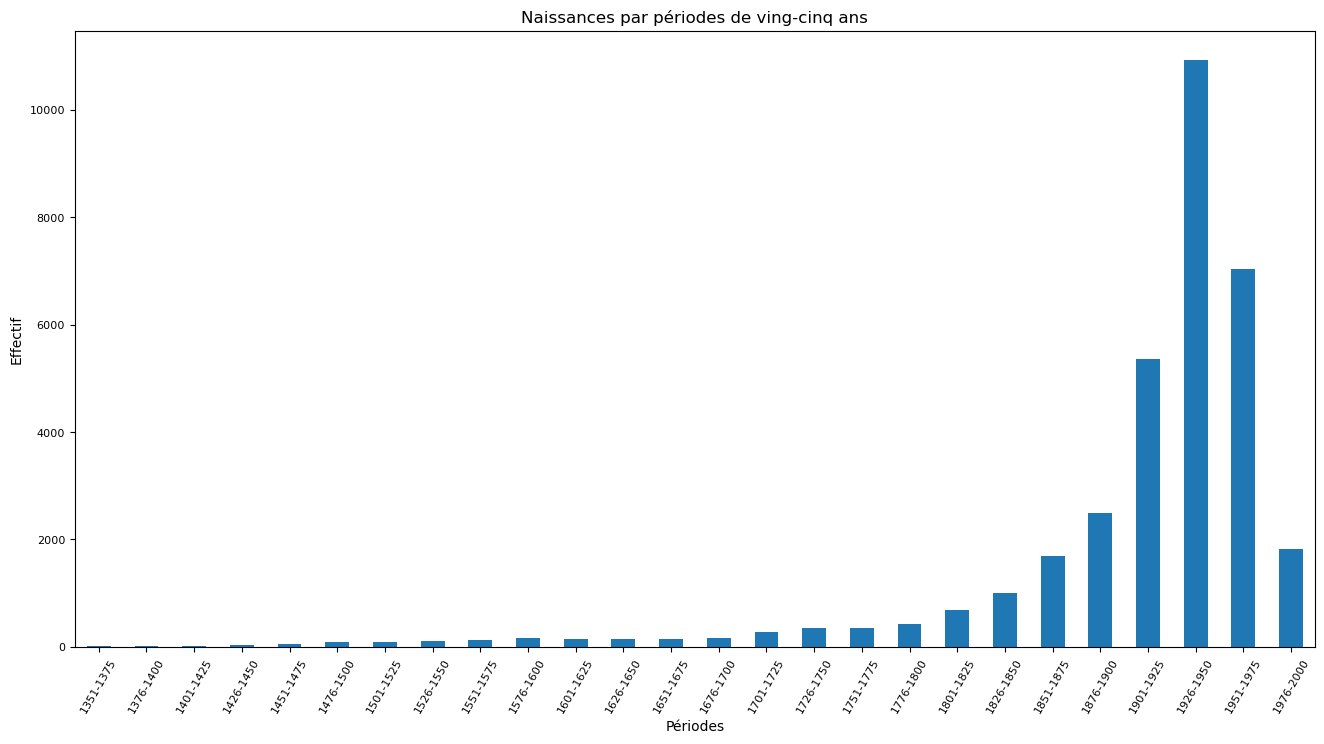

In [47]:
ax = cdf_b.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

In [48]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
gender_m = pd.DataFrame(cdf_b[cdf_b.genCode == 'M'].groupby('periodes').size())
gender_m.columns = ['gen_m']
gender_m.tail()


,gen_m
periodes,
1876-1900,2318
1901-1925,4981
1926-1950,10174
1951-1975,6020
1976-2000,1377


In [49]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
gender_f = pd.DataFrame(cdf_b[cdf_b.genCode == 'F'].groupby('periodes').size())
gender_f.columns = ['gen_f']
gender_f.tail()


,gen_f
periodes,
1876-1900,181
1901-1925,373
1926-1950,747
1951-1975,1018
1976-2000,431


In [50]:
merged = pd.merge(gender_m, gender_f, left_index=True, right_index=True)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,2318,181
1901-1925,4981,373
1926-1950,10174,747
1951-1975,6020,1018
1976-2000,1377,431


In [51]:
merged.index = merged.index.map(str)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,2318,181
1901-1925,4981,373
1926-1950,10174,747
1951-1975,6020,1018
1976-2000,1377,431


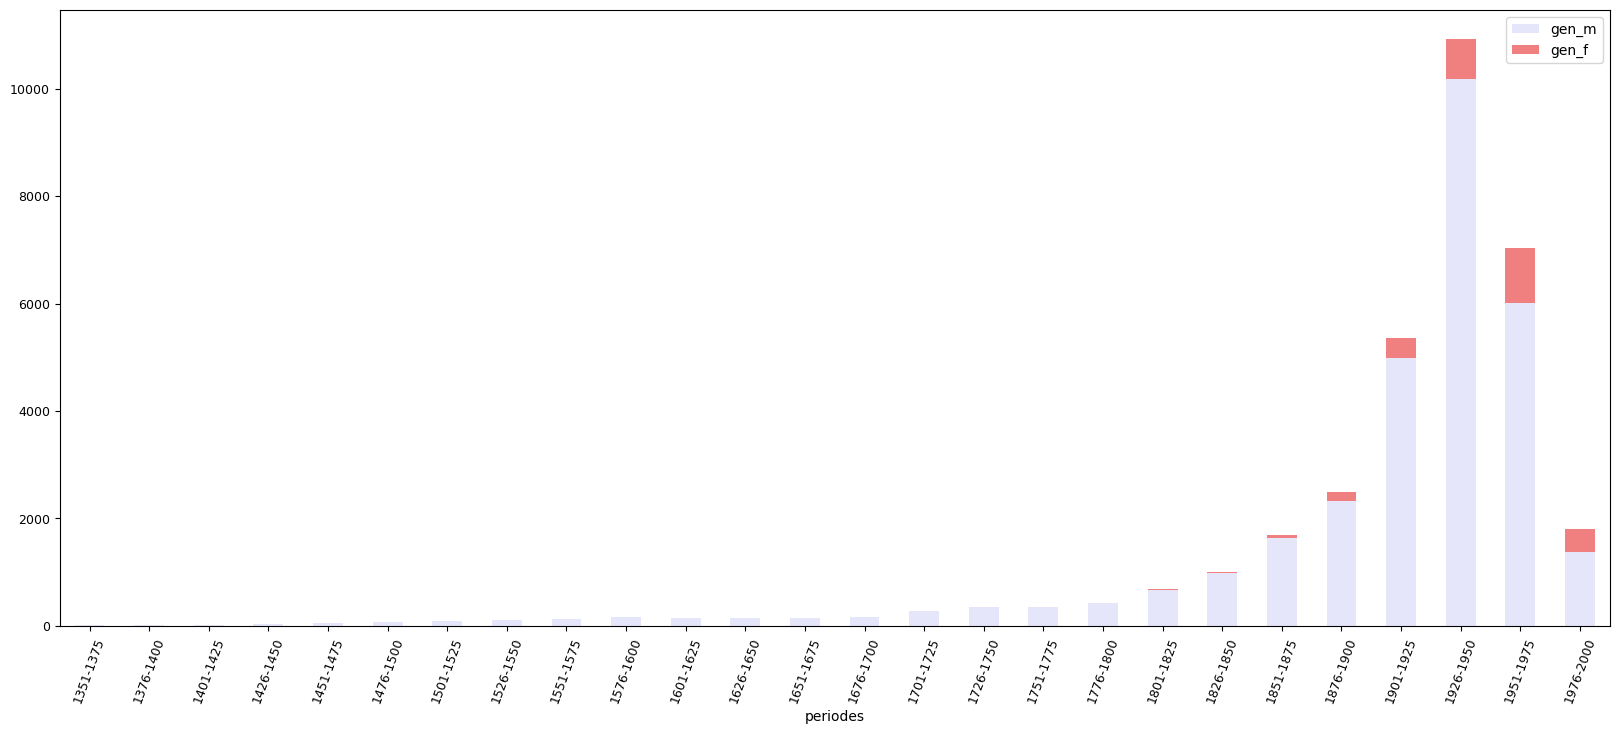

In [52]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8), color=['Lavender', 'LightCoral'])
plt.show()

### Codage par période de dix ans

In [53]:
l_10 = list(range(1851, 2002, 10))
l_10[:5],l_10[-5:]

([1851, 1861, 1871, 1881, 1891], [1961, 1971, 1981, 1991, 2001])

In [54]:

## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html


cdf_b['per_10'] = pd.cut(cdf_b['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_b['per_10'] = cdf_b['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_b.head(3)

,personUri,personLabel,genderUri,birthYear,genCode,periodes,per_10
0,http://www.wikidata.org/entity/Q855257,Blasius of Parma,http://www.wikidata.org/entity/Q6581097,1355,M,1351-1375,NaN
1,http://www.wikidata.org/entity/Q4121967,Ibn al-Majdi,http://www.wikidata.org/entity/Q6581097,1359,M,1351-1375,NaN
2,http://www.wikidata.org/entity/Q9168741,Benedict Makra,http://www.wikidata.org/entity/Q6581097,1360,M,1351-1375,NaN


In [55]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
gender_m_10 = pd.DataFrame(cdf_b[(cdf_b.genCode == 'M') & (cdf_b.birthYear > 1850)].groupby('per_10').size())
gender_m_10.columns = ['gen_m']
gender_m_10.tail()


,gen_m
per_10,
1951-1960,3110
1961-1970,2163
1971-1980,1279
1981-1990,487
1991-2000,358


In [56]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
gender_f_10 = pd.DataFrame(cdf_b[(cdf_b.genCode == 'F')& (cdf_b.birthYear > 1850)].groupby('per_10').size())
gender_f_10.columns = ['gen_f']
gender_f_10.tail()


,gen_f
per_10,
1951-1960,412
1961-1970,416
1971-1980,346
1981-1990,198
1991-2000,77


In [57]:
merged_10 = pd.merge(gender_m_10, gender_f_10, left_index=True, right_index=True)
merged_10.tail()

,gen_m,gen_f
per_10,,
1951-1960,3110,412
1961-1970,2163,416
1971-1980,1279,346
1981-1990,487,198
1991-2000,358,77


In [58]:
merged_10.index = merged_10.index.map(str)
merged_10.tail()

,gen_m,gen_f
per_10,,
1951-1960,3110,412
1961-1970,2163,416
1971-1980,1279,346
1981-1990,487,198
1991-2000,358,77


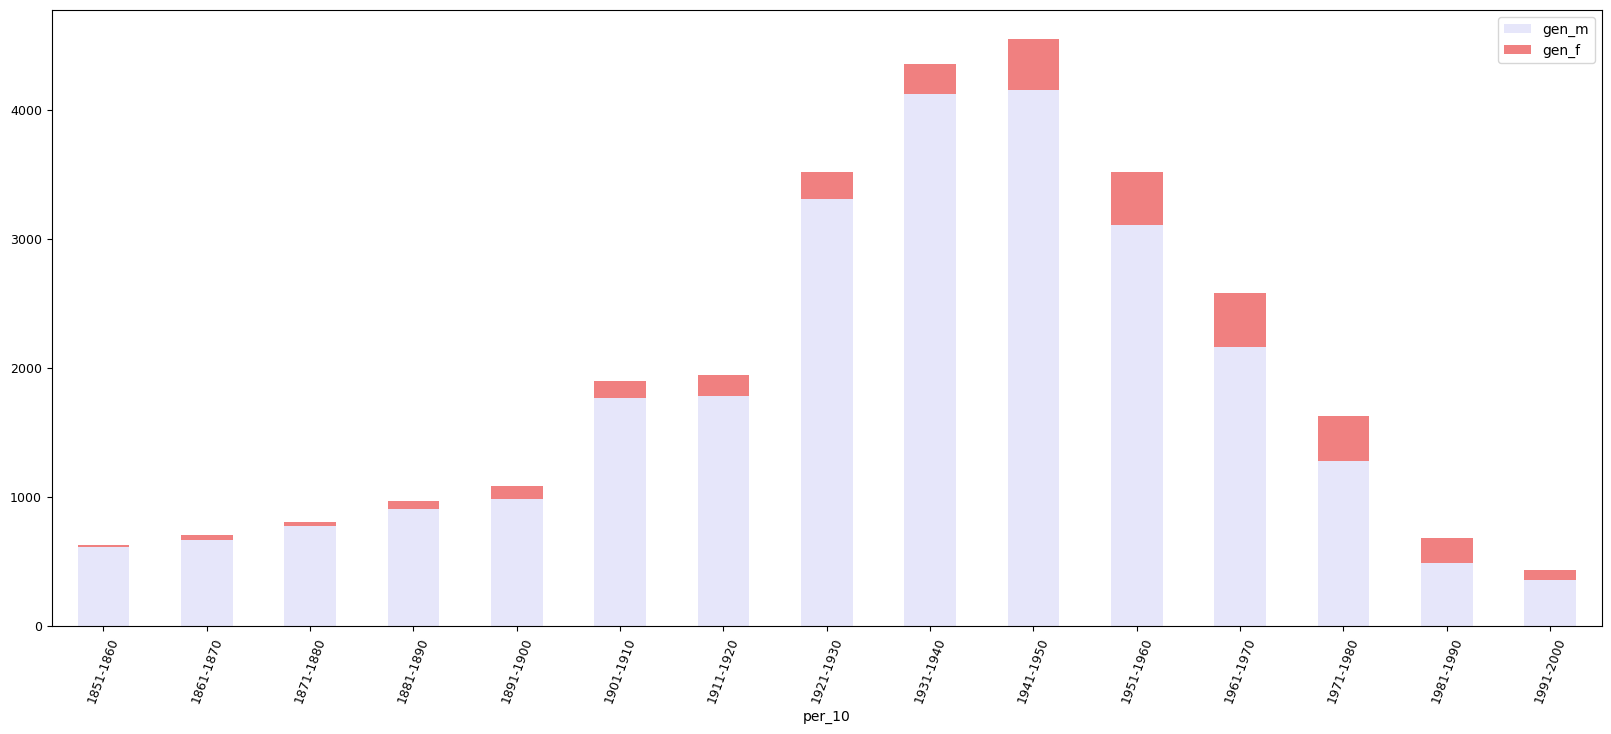

In [59]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged_10.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8), color=['Lavender', 'LightCoral'])
plt.show()

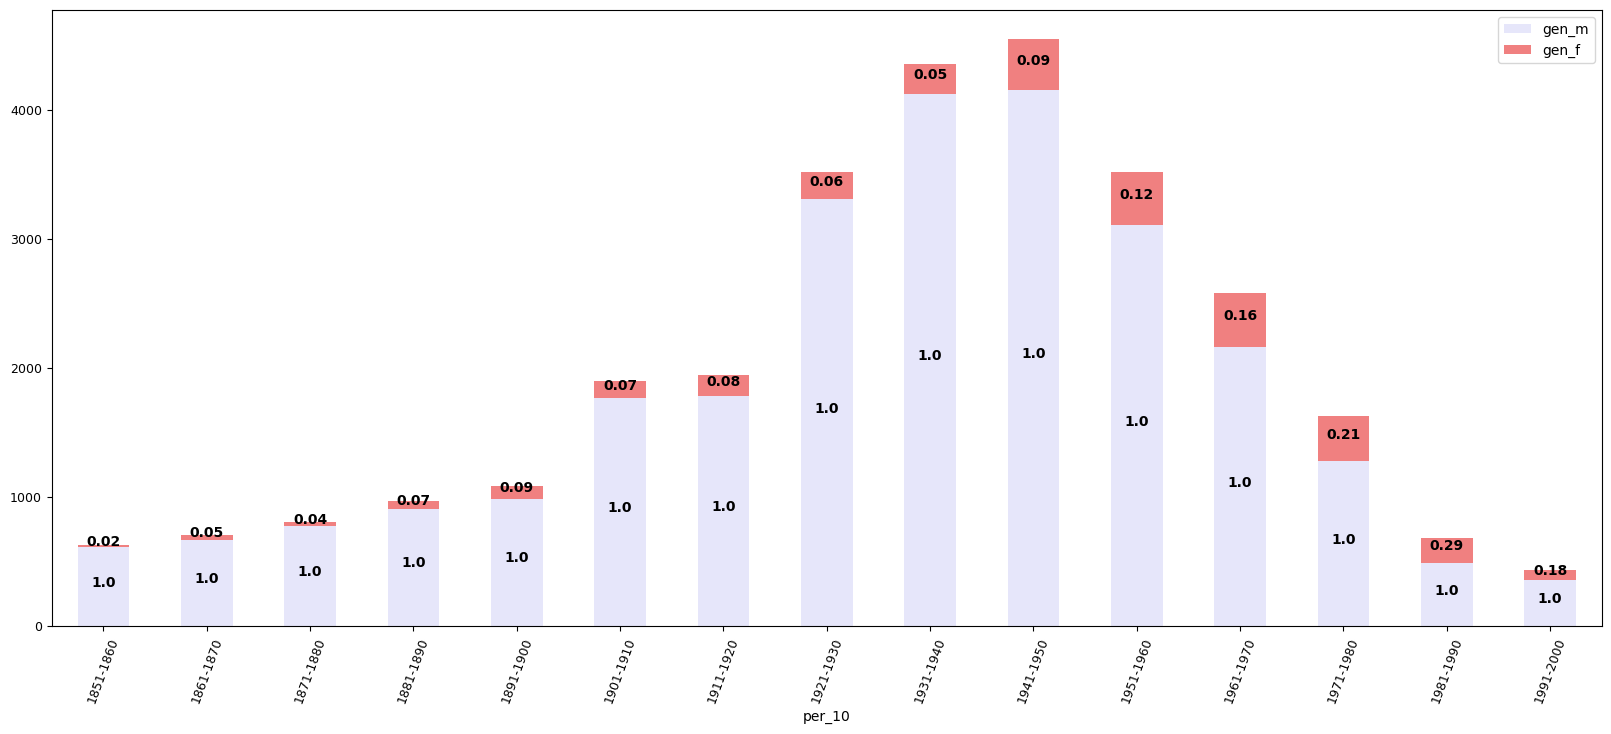

In [60]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged_10.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8), color=['Lavender', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/

# Let's put the annotations inside the bars themselves by using a
# negative offset.
y_offset = -200

# For each patch (basically each rectangle within the bar), add a label.
for bar in ax.patches:
  ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height()/2 + bar.get_y(), #+ y_offset,
      # This is actual value we'll show.
      round(bar.get_height()/(bar.get_height() + bar.get_y()), 2),
      #round(bar.get_height()/(bar.get_height() + bar.get_y()), 2),
      # Center the labels and style them a bit.
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.show()

15
[610.0, 0.0]
610.0
[669.0, 0.0]
669.0
[774.0, 0.0]
774.0
[908.0, 0.0]
908.0
[988.0, 0.0]
988.0
[1769.0, 0.0]
1769.0
[1786.0, 0.0]
1786.0
[3311.0, 0.0]
3311.0
[4129.0, 0.0]
4129.0
[4160.0, 0.0]
4160.0
[3110.0, 0.0]
3110.0
[2163.0, 0.0]
2163.0
[1279.0, 0.0]
1279.0
[487.0, 0.0]
487.0
[358.0, 0.0]
358.0
[15.0, 610.0]
15.0
[38.0, 669.0]
38.0
[35.0, 774.0]
35.0
[64.0, 908.0]
64.0
[98.0, 988.0]
98.0
[130.0, 1769.0]
130.0
[157.0, 1786.0]
157.0
[211.0, 3311.0]
211.0
[231.0, 4129.0]
231.0
[391.0, 4160.0]
391.0
[412.0, 3110.0]
412.0
[416.0, 2163.0]
416.0
[346.0, 1279.0]
346.0
[198.0, 487.0]
198.0
[77.0, 358.0]
77.0


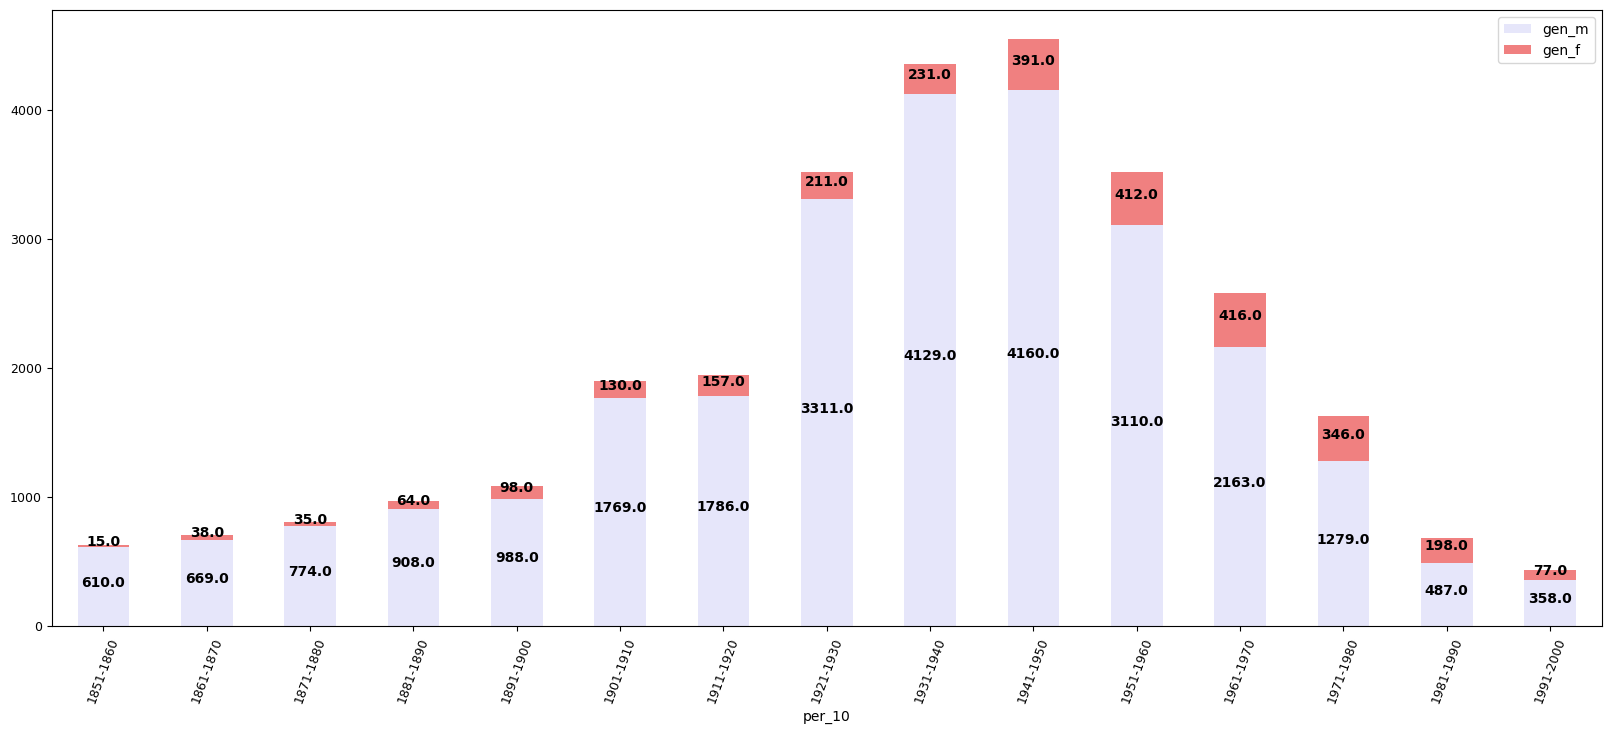

In [73]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged_10.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8), color=['Lavender', 'LightCoral'])

### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/

# Let's put the annotations inside the bars themselves by using a
# negative offset.
y_offset = -200


l = (round(len(ax.patches)/2))
print(l)
i=0
# For each patch (basically each rectangle within the bar), add a label.
for bar in ax.patches[:]:
    print([bar.get_height(), bar.get_y()] )
    if i < l:
        print(bar.get_height() )
    else:
        print(bar.get_y())
    # i =+ 1
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height()/2 + bar.get_y(), #+ y_offset,
      # This is actual value we'll show.
      #round((bar.get_height())/(bar.get_height() + bar.get_y()), 2),
      round(bar.get_height(), 2),
      # Center the labels and style them a bit.
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.show()